In [1]:
%matplotlib inline 

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,in_sess_time,dist_low_14,atr_pct_56,atr_pct_28,atr_pct_7,ret_std_56,dist_low_56,ret_std_28,ret_std_14,dist_low_28,bb_w_10,bb_w_20,ret_std_7,dist_low_112,eng_ema_cross_down,mom_std_5,bb_w_80,range_pct,mom_std_15,hour_time,minute_time,mom_std_60,rsi_7,eng_vwap,rsi_14,rsi_28,plus_di_7,ema_dev_14,plus_di_14,ema_dev_7,eng_bb_mid,adx_56,eng_rsi,plus_di_28,obv_diff_7,sma_pct_7,roc_7,vwap_dev_pct_14,dist_high_112,adx_14,z_bbw_80,dist_high_56,close_raw,signal
2004-01-02 11:18:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.497478,1.000000,1.000000,0.000000,0.511325,0.000000,0.513015,0.486806,0.000000,1.000000,0.000000,0.516555,0.509319,0.504418,0.506791,0.000000,0.000000,0.363469,0.000000,0.764286,0.000008
2004-01-02 11:19:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.001718,0.000000,1.000000,0.497478,1.000000,1.000000,0.000000,0.511325,0.000000,0.513015,0.486806,0.000000,1.000000,0.000000,0.516555,0.509319,0.504418,0.506791,0.000000,0.000000,0.363469,0.000000,0.764286,0.000008
2004-01-02 11:20:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.003436,0.000000,1.000000,0.497478,1.000000,1.000000,0.000000,0.511325,0.000000,0.513015,0.486806,0.000000,1.000000,0.000000,0.516555,0.509319,0.504418,0.506791,0.000000,0.000000,0.363469,0.000000,0.764286,0.000009
2004-01-02 11:21:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.005155,0.000000,1.000000,0.497478,1.000000,1.000000,0.000000,0.511325,0.000000,0.513015,0.486806,0.000000,1.000000,0.000000,0.516555,0.509319,0.504418,0.506791,0.000000,0.000000,0.363469,0.000000,0.764286,0.000009
2004-01-02 11:22:00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.006873,0.000000,1.000000,0.497478,1.000000,1.000000,0.000000,0.511325,0.000000,0.513015,0.486806,0.000000,1.000000,0.000000,0.516555,0.509319,0.504418,0.506791,0.000000,0.000000,0.363469,0.000000,0.764286,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,1.0,0.189237,0.096690,0.107201,0.141006,0.158553,0.217663,0.140502,0.169780,0.229824,0.154211,0.113349,0.216461,0.159817,0.0,0.121075,0.115071,0.089736,0.085791,0.9,0.993127,0.146120,0.724623,0.589620,0.672166,0.617664,0.390325,0.632227,0.363125,0.630058,0.372388,0.099667,0.082077,0.314685,1.000000,0.614859,0.615914,0.590870,0.000000,0.301944,0.485148,0.000000,196.815000,0.165471
2025-06-18 20:57:00,1.0,0.150384,0.098316,0.110017,0.146491,0.160651,0.192555,0.145529,0.175111,0.173225,0.143992,0.120264,0.198192,0.145804,0.0,0.118340,0.117500,0.148365,0.088657,0.9,0.994845,0.149738,0.618654,0.534191,0.616686,0.589768,0.358974,0.577767,0.347207,0.551266,0.433034,0.102293,0.000000,0.308463,0.685566,0.555890,0.518988,0.540268,0.014934,0.328685,0.500196,0.020080,196.675000,0.148438
2025-06-18 20:58:00,1.0,0.148995,0.097514,0.107993,0.132962,0.160702,0.190459,0.143626,0.175015,0.142889,0.137297,0.125952,0.123503,0.145303,0.0,0.130258,0.120126,0.042949,0.085517,0.9,0.996564,0.153718,0.614908,0.525384,0.614734,0.588783,0.339010,0.567531,0.336272,0.539932,0.446564,0.104873,0.000000,0.303030,0.443956,0.530652,0.590803,0.532237,0.015468,0.353515,0.515529,0.020797,196.670000,0.147712
2025-06-18 20:59:00,1.0,0.029306,0.100402,0.113203,0.148575,0.175587,0.130526,0.169081,0.214454,0.058850,0.142259,0.126387,0.215018,0.102137,0.0,0.208

In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

N_total: 2435400 look_back: 60 F: 42
Estimated X_buf size: 24.55 GB — using RAM (in-memory) (thresh 35 GiB)


Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [5]:
for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


--- TRAIN ---
 calendar days : 3792  (2004-01-02 → 2019-01-25)
 windows       : 1710192  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=42
 dataloader    : batches=237, batch_size=16, workers=8, pin_memory=True
 baselines     : baseline prediction=0.0993602, baseline RMSE = 0.113791

--- VAL ---
 calendar days : 799  (2019-01-28 → 2022-03-28)
 windows       : 360349  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=42
 dataloader    : batches=799, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.09857, baseline RMSE = 0.108622

--- TEST ---
 calendar days : 809  (2022-03-29 → 2025-06-18)
 windows       : 364859  (per-day min=451, max=451, mean=451.0)
 window shape  : look_back=60, n_features=42
 dataloader    : batches=809, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.094252, baseline RMSE = 0.102559



In [6]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats             = len(params.features_cols_tick),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = params.features_cols_tick # for logging
model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (feature_proj): Linear(in_features=42, out_features=96, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=384, bias=True)
        (dropout): Dropout(p=0.15, inplace=False)
        (linear2): Linear(in_features=384, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.15, inplace=False)
        (dropout2): Dropout(p=0.15, inplace=False)
      )
    )
  )
  (

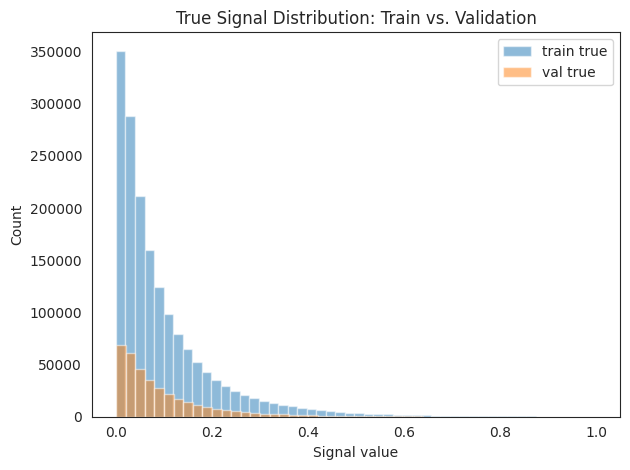

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

Training sees 3792 unique trading days per epoch.

Model parameters: total=369,475, trainable=369,475

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 3, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 128, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.15, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 96, 'TRANSFORMER_LAYERS': 3, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.15, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.1, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'pool', 'PRED_HIDDEN': 128, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 0.0001, 'CLIPNORM': 3, 'ONECYCLE_MAX_LR': 0.0008, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAI

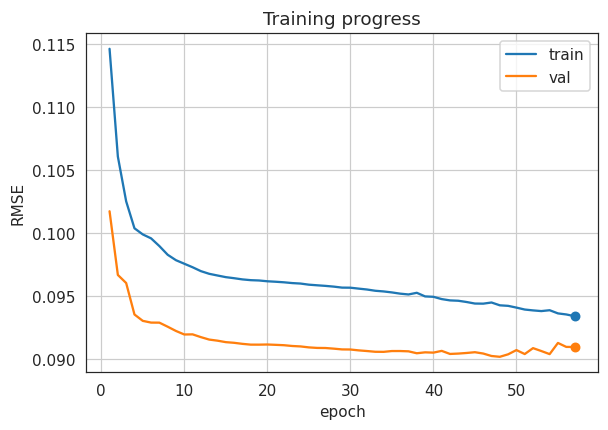

Epoch 1 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

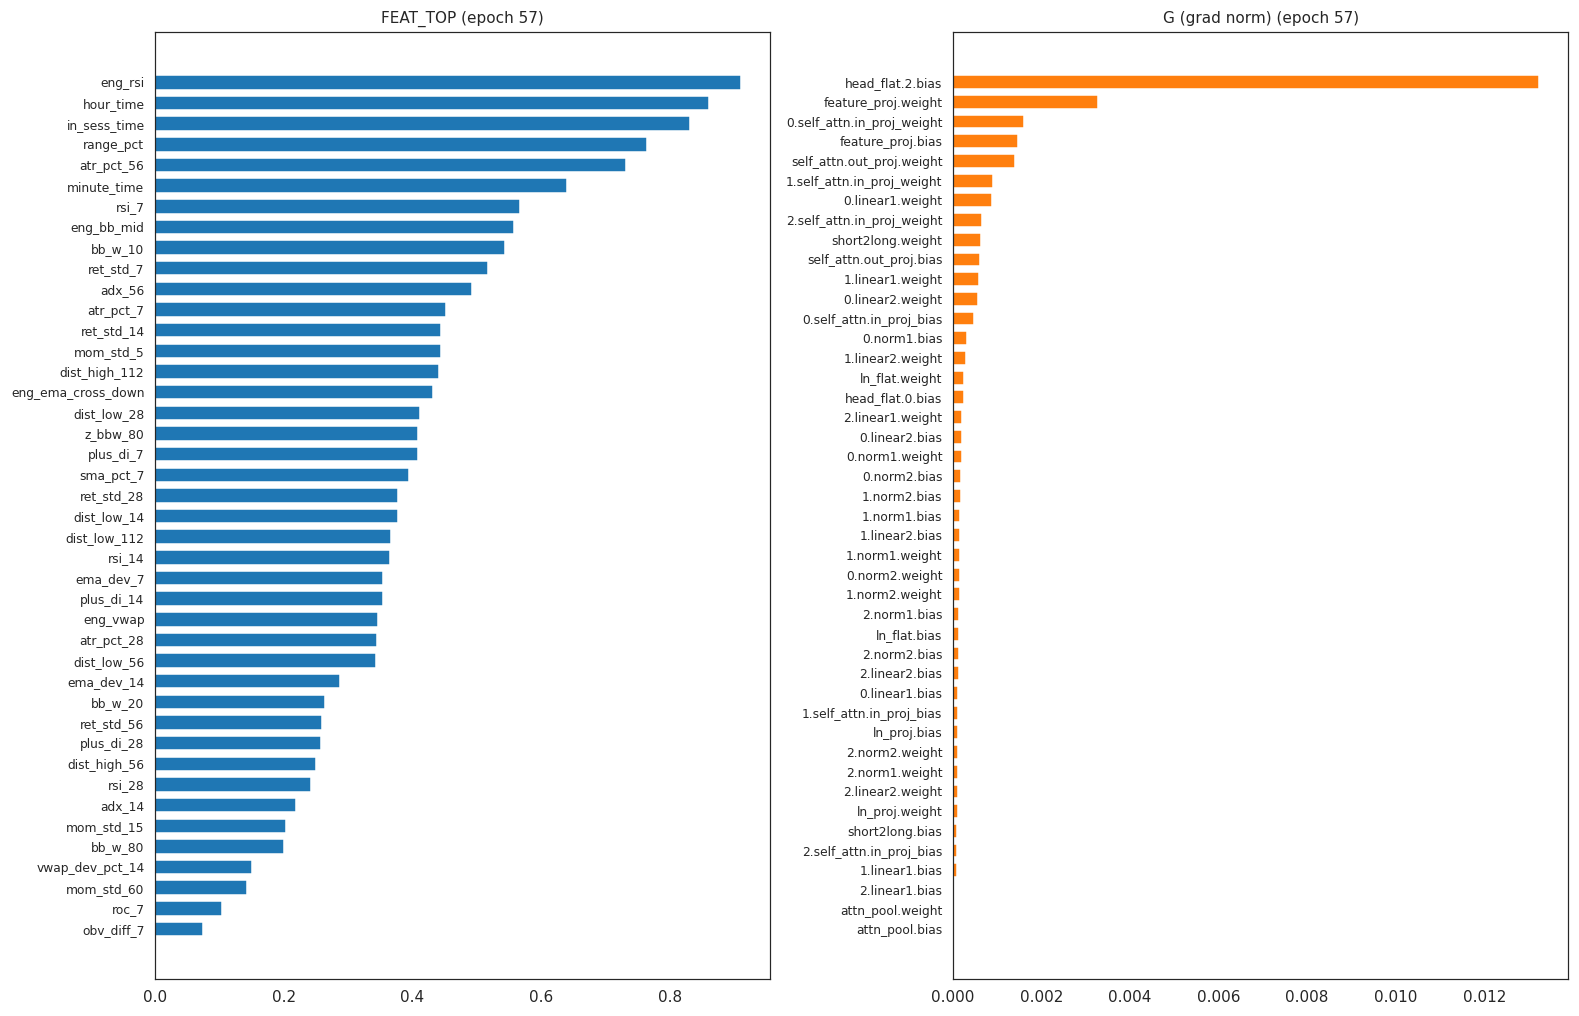

Epoch 01  TRAIN→ RMSE=0.11461, R²=-0.014 |  VALID→ RMSE=0.10173, R²=0.123 |  lr=1.02e-04 |  loss=1.31354e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10606, R²=0.131 |  VALID→ RMSE=0.09668, R²=0.208 |  lr=1.64e-04 |  loss=1.12496e-02 |  improved=True


Epoch 3 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.10252, R²=0.188 |  VALID→ RMSE=0.09604, R²=0.218 |  lr=2.60e-04 |  loss=1.05095e-02 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.10038, R²=0.222 |  VALID→ RMSE=0.09354, R²=0.258 |  lr=3.78e-04 |  loss=1.00757e-02 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.09989, R²=0.229 |  VALID→ RMSE=0.09304, R²=0.266 |  lr=5.03e-04 |  loss=9.97863e-03 |  improved=True


Epoch 6 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.09958, R²=0.234 |  VALID→ RMSE=0.09290, R²=0.269 |  lr=6.20e-04 |  loss=9.91615e-03 |  improved=True


Epoch 7 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.09897, R²=0.244 |  VALID→ RMSE=0.09290, R²=0.269 |  lr=7.16e-04 |  loss=9.79461e-03 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.09828, R²=0.254 |  VALID→ RMSE=0.09257, R²=0.274 |  lr=7.78e-04 |  loss=9.65860e-03 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.09785, R²=0.261 |  VALID→ RMSE=0.09224, R²=0.279 |  lr=8.00e-04 |  loss=9.57404e-03 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.09757, R²=0.265 |  VALID→ RMSE=0.09196, R²=0.283 |  lr=8.00e-04 |  loss=9.51942e-03 |  improved=True


Epoch 11 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.09729, R²=0.269 |  VALID→ RMSE=0.09197, R²=0.283 |  lr=7.99e-04 |  loss=9.46509e-03 |  improved=False


Epoch 12 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.09698, R²=0.274 |  VALID→ RMSE=0.09175, R²=0.287 |  lr=7.97e-04 |  loss=9.40518e-03 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.09677, R²=0.277 |  VALID→ RMSE=0.09155, R²=0.290 |  lr=7.95e-04 |  loss=9.36417e-03 |  improved=True


Epoch 14 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.09663, R²=0.279 |  VALID→ RMSE=0.09147, R²=0.291 |  lr=7.92e-04 |  loss=9.33821e-03 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.09650, R²=0.281 |  VALID→ RMSE=0.09135, R²=0.293 |  lr=7.89e-04 |  loss=9.31300e-03 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.09642, R²=0.282 |  VALID→ RMSE=0.09130, R²=0.294 |  lr=7.85e-04 |  loss=9.29681e-03 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.09633, R²=0.283 |  VALID→ RMSE=0.09121, R²=0.295 |  lr=7.81e-04 |  loss=9.27859e-03 |  improved=True


Epoch 18 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.09627, R²=0.284 |  VALID→ RMSE=0.09115, R²=0.296 |  lr=7.76e-04 |  loss=9.26699e-03 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.09624, R²=0.285 |  VALID→ RMSE=0.09115, R²=0.296 |  lr=7.70e-04 |  loss=9.26208e-03 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.09618, R²=0.286 |  VALID→ RMSE=0.09116, R²=0.296 |  lr=7.64e-04 |  loss=9.25005e-03 |  improved=False


Epoch 21 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.09614, R²=0.286 |  VALID→ RMSE=0.09114, R²=0.296 |  lr=7.57e-04 |  loss=9.24287e-03 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.09610, R²=0.287 |  VALID→ RMSE=0.09111, R²=0.296 |  lr=7.50e-04 |  loss=9.23433e-03 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.09603, R²=0.288 |  VALID→ RMSE=0.09105, R²=0.297 |  lr=7.42e-04 |  loss=9.22248e-03 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.09600, R²=0.288 |  VALID→ RMSE=0.09101, R²=0.298 |  lr=7.34e-04 |  loss=9.21519e-03 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 25  TRAIN→ RMSE=0.09591, R²=0.290 |  VALID→ RMSE=0.09093, R²=0.299 |  lr=7.25e-04 |  loss=9.19817e-03 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 26  TRAIN→ RMSE=0.09586, R²=0.290 |  VALID→ RMSE=0.09089, R²=0.300 |  lr=7.16e-04 |  loss=9.18886e-03 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 27  TRAIN→ RMSE=0.09581, R²=0.291 |  VALID→ RMSE=0.09089, R²=0.300 |  lr=7.06e-04 |  loss=9.17986e-03 |  improved=True


Epoch 28 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 28  TRAIN→ RMSE=0.09575, R²=0.292 |  VALID→ RMSE=0.09083, R²=0.301 |  lr=6.96e-04 |  loss=9.16867e-03 |  improved=True


Epoch 29 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.09567, R²=0.293 |  VALID→ RMSE=0.09077, R²=0.302 |  lr=6.86e-04 |  loss=9.15348e-03 |  improved=True


Epoch 30 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.09567, R²=0.293 |  VALID→ RMSE=0.09077, R²=0.302 |  lr=6.75e-04 |  loss=9.15229e-03 |  improved=True


Epoch 31 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.09559, R²=0.294 |  VALID→ RMSE=0.09070, R²=0.303 |  lr=6.63e-04 |  loss=9.13824e-03 |  improved=True


Epoch 32 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.09552, R²=0.295 |  VALID→ RMSE=0.09065, R²=0.304 |  lr=6.51e-04 |  loss=9.12488e-03 |  improved=True


Epoch 33 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 33  TRAIN→ RMSE=0.09542, R²=0.297 |  VALID→ RMSE=0.09059, R²=0.304 |  lr=6.39e-04 |  loss=9.10591e-03 |  improved=True


Epoch 34 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 34  TRAIN→ RMSE=0.09537, R²=0.298 |  VALID→ RMSE=0.09058, R²=0.305 |  lr=6.26e-04 |  loss=9.09573e-03 |  improved=True


Epoch 35 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 35  TRAIN→ RMSE=0.09529, R²=0.299 |  VALID→ RMSE=0.09064, R²=0.304 |  lr=6.13e-04 |  loss=9.08080e-03 |  improved=False


Epoch 36 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.09520, R²=0.300 |  VALID→ RMSE=0.09065, R²=0.304 |  lr=6.00e-04 |  loss=9.06210e-03 |  improved=False


Epoch 37 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.09513, R²=0.301 |  VALID→ RMSE=0.09062, R²=0.304 |  lr=5.87e-04 |  loss=9.04997e-03 |  improved=False


Epoch 38 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 38  TRAIN→ RMSE=0.09526, R²=0.299 |  VALID→ RMSE=0.09047, R²=0.306 |  lr=5.73e-04 |  loss=9.07510e-03 |  improved=True


Epoch 39 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 39  TRAIN→ RMSE=0.09498, R²=0.303 |  VALID→ RMSE=0.09054, R²=0.305 |  lr=5.59e-04 |  loss=9.02056e-03 |  improved=False


Epoch 40 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 40  TRAIN→ RMSE=0.09495, R²=0.304 |  VALID→ RMSE=0.09052, R²=0.306 |  lr=5.44e-04 |  loss=9.01467e-03 |  improved=False


Epoch 41 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 41  TRAIN→ RMSE=0.09476, R²=0.306 |  VALID→ RMSE=0.09066, R²=0.303 |  lr=5.30e-04 |  loss=8.98035e-03 |  improved=False


Epoch 42 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 42  TRAIN→ RMSE=0.09466, R²=0.308 |  VALID→ RMSE=0.09041, R²=0.307 |  lr=5.15e-04 |  loss=8.96069e-03 |  improved=True


Epoch 43 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 43  TRAIN→ RMSE=0.09463, R²=0.308 |  VALID→ RMSE=0.09044, R²=0.307 |  lr=5.00e-04 |  loss=8.95532e-03 |  improved=False


Epoch 44 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 44  TRAIN→ RMSE=0.09453, R²=0.310 |  VALID→ RMSE=0.09049, R²=0.306 |  lr=4.85e-04 |  loss=8.93636e-03 |  improved=False


Epoch 45 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 45  TRAIN→ RMSE=0.09441, R²=0.312 |  VALID→ RMSE=0.09055, R²=0.305 |  lr=4.70e-04 |  loss=8.91337e-03 |  improved=False


Epoch 46 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 46  TRAIN→ RMSE=0.09440, R²=0.312 |  VALID→ RMSE=0.09045, R²=0.307 |  lr=4.55e-04 |  loss=8.91178e-03 |  improved=False


Epoch 47 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 47  TRAIN→ RMSE=0.09449, R²=0.310 |  VALID→ RMSE=0.09025, R²=0.310 |  lr=4.39e-04 |  loss=8.92905e-03 |  improved=True


Epoch 48 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 48  TRAIN→ RMSE=0.09427, R²=0.314 |  VALID→ RMSE=0.09019, R²=0.311 |  lr=4.24e-04 |  loss=8.88695e-03 |  improved=True


Epoch 49 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 49  TRAIN→ RMSE=0.09423, R²=0.314 |  VALID→ RMSE=0.09039, R²=0.308 |  lr=4.08e-04 |  loss=8.87899e-03 |  improved=False


Epoch 50 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 50  TRAIN→ RMSE=0.09409, R²=0.316 |  VALID→ RMSE=0.09072, R²=0.302 |  lr=3.93e-04 |  loss=8.85277e-03 |  improved=False


Epoch 51 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 51  TRAIN→ RMSE=0.09394, R²=0.319 |  VALID→ RMSE=0.09041, R²=0.307 |  lr=3.77e-04 |  loss=8.82398e-03 |  improved=False


Epoch 52 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 52  TRAIN→ RMSE=0.09387, R²=0.320 |  VALID→ RMSE=0.09088, R²=0.300 |  lr=3.62e-04 |  loss=8.81107e-03 |  improved=False


Epoch 53 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 53  TRAIN→ RMSE=0.09381, R²=0.320 |  VALID→ RMSE=0.09064, R²=0.304 |  lr=3.46e-04 |  loss=8.80092e-03 |  improved=False


Epoch 54 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 54  TRAIN→ RMSE=0.09388, R²=0.319 |  VALID→ RMSE=0.09040, R²=0.307 |  lr=3.31e-04 |  loss=8.81374e-03 |  improved=False


Epoch 55 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 55  TRAIN→ RMSE=0.09363, R²=0.323 |  VALID→ RMSE=0.09129, R²=0.294 |  lr=3.16e-04 |  loss=8.76658e-03 |  improved=False


Epoch 56 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 56  TRAIN→ RMSE=0.09355, R²=0.324 |  VALID→ RMSE=0.09097, R²=0.299 |  lr=3.01e-04 |  loss=8.75094e-03 |  improved=False


Epoch 57 ▶ Train:   0%|          | 0/237 [00:00<?, ?it/s]

eval:   0%|          | 0/799 [00:00<?, ?it/s]

Epoch 57  TRAIN→ RMSE=0.09341, R²=0.326 |  VALID→ RMSE=0.09097, R²=0.299 |  lr=2.86e-04 |  loss=8.72547e-03 |  improved=False
✅ Final‐best model saved: AAPL_0.09019_fin.pth


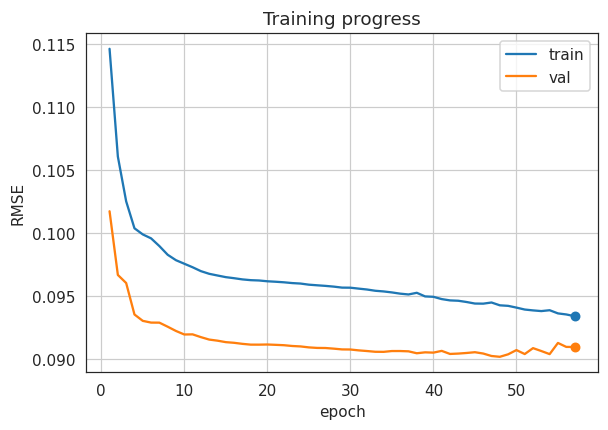

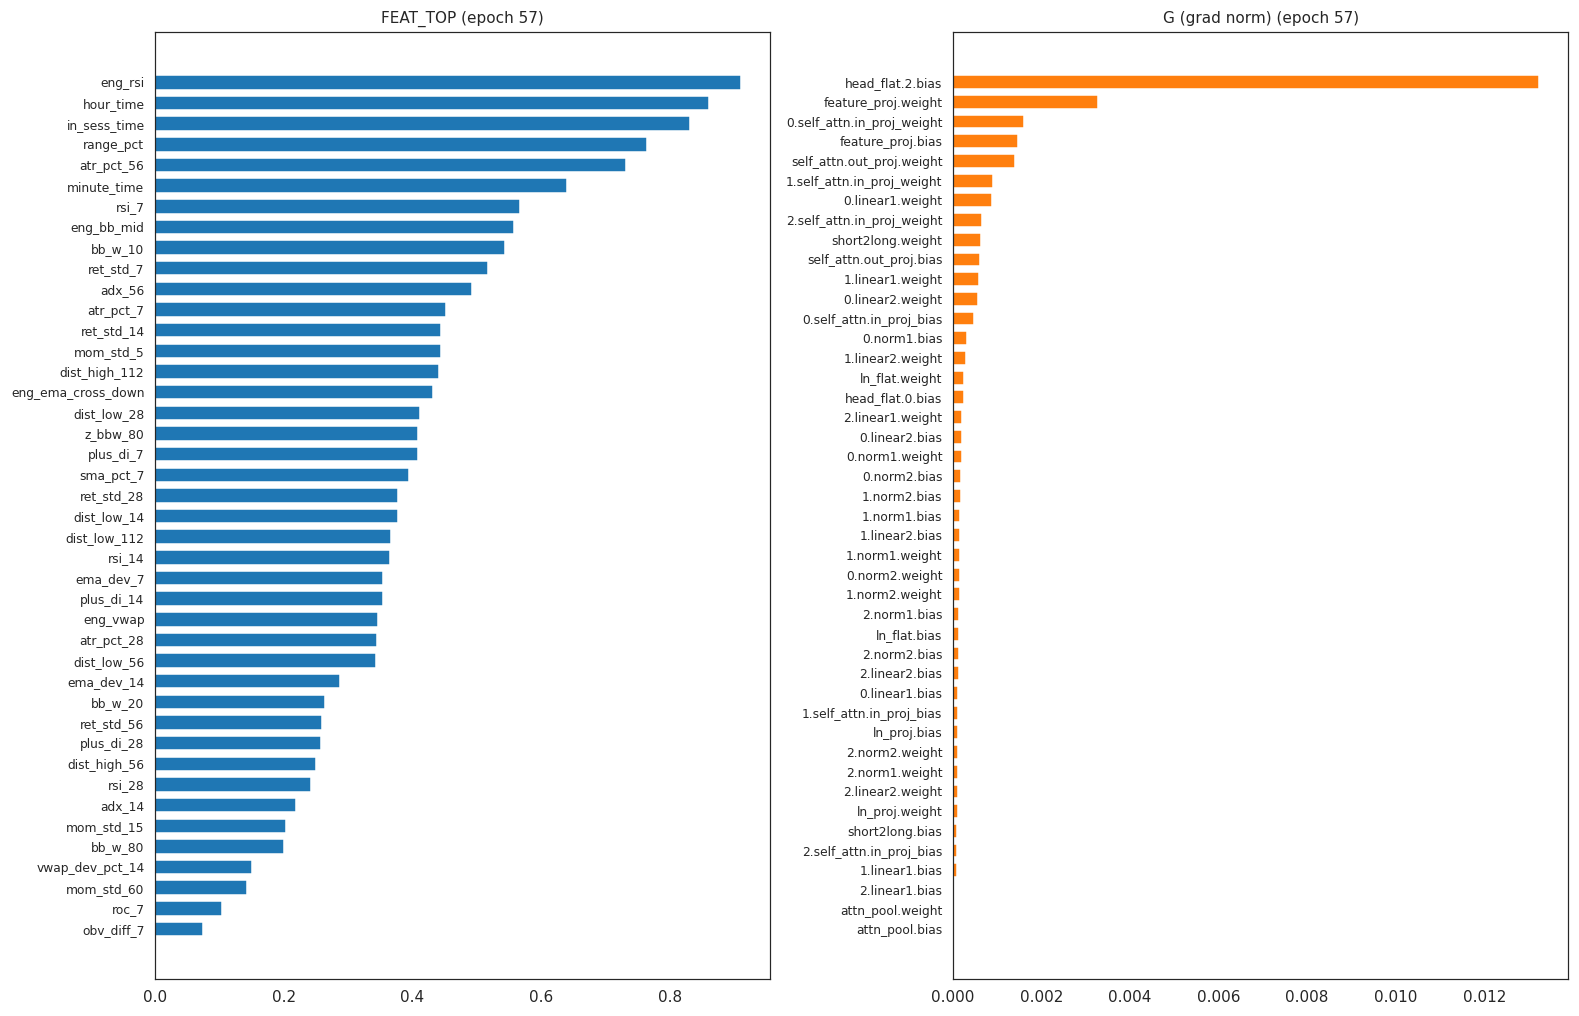

In [9]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader
)